In [1]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import pandas as pd

from tqdm.auto import tqdm

In [2]:
from implementations import *
from helpers import *

y, X, ids = load_csv_data("data/train.csv")
y[y == -1] = 0

In [3]:
# X = standardize(X)[0]

In [4]:
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
y.shape, X.shape

((250000,), (250000, 31))

In [5]:
def imputer(data):
    data[data == -999] = np.nan
    col_mean = np.nanmedian(data, axis=0)
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])
    return data


In [6]:
data = np.concatenate((y.reshape(y.shape[0], 1), X), axis=1)

In [7]:
# data_test = pd.read_csv('data/test.csv')
# X_test = np.array(data_test)[:, 2:]
# # X_test = standardize(X_test)[0]
# X_test = np.concatenate((X_test, np.ones((len(X_test), 1))), axis=1)
# X_test.shape

In [8]:
X_test = np.genfromtxt('data/test.csv', delimiter=",", skip_header=1)
X_test = X_test[:, 2:]
X_test = np.concatenate((X_test, np.ones((len(X_test), 1))), axis=1)
X_test.shape

(568238, 31)

In [9]:
X = imputer(X)
X_test = imputer(X_test)

In [10]:
X, _, _ = standardize(X)
X_test, _, _ = standardize(X_test)

In [11]:
X.shape

(250000, 31)

In [12]:
X_test.shape

(568238, 31)

In [13]:
def normalize(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    mean[std == 0] = 0
    std[std == 0] = 1
    return (X_train - mean) / std, (X_test - mean) / std

In [14]:
def knn_all_k(X_train, y_train, X_test, k):
#     print(X_train.shape)
#     print(X_test.shape)
    
    
#     X_train, X_test = normalize(X_train, X_test)
    
    X_train_sqr = np.sum(X_train ** 2, axis=1)
    X_test_sqr = np.sum(X_test ** 2, axis=1)

    dists = X_test_sqr[:, None] - 2 * X_test @ X_train.T + X_train_sqr[None, :]

    min_dists = np.argpartition(dists, k - 1, axis=1)[:, :k]
    
    dists = dists[np.arange(len(dists))[:, None], min_dists]
   
    min_dists2 = np.argsort(dists, axis=1)
    
    ys3 = np.cumsum(y_train[min_dists[np.arange(len(min_dists2))[:, None], min_dists2]], axis = 1) / (np.arange(k) + 1)
    ys3 = (ys3 >= 0.5).astype(np.float64)
    
    return ys3

In [15]:
from tqdm.auto import tqdm, trange

# Cross-validation
def cross_validation(X, y, method, k):
    
#     print(k)
    
    X_train, X_test, y_train, y_test = split_data(X, y, 0.8)

    BATCH_SZ = 512
    y_pred_array = []
    print('len', len(X_test))
    
    for i in trange(0, len(X_test), BATCH_SZ):
        y_pred_array.append(knn_all_k(X_train, y_train, X_test[i:i + BATCH_SZ], k))
        
    y_pred = np.concatenate(y_pred_array)
    
    
    accuracy = []
    for i in range(k):
        accuracy.append(np.sum(y_pred[:, i] == y_test) / len(y_test))
#     loo_mses = []
#     for i in range(k):
#         loo_mses.append( np.mean((y_pred[:, i] - y_test)**2))
        
    return accuracy

In [16]:
def knn(X_train, y_train, X_test, k):
#     X_train, X_test = normalize(X_train, X_test)
    
    X_train_sqr = np.sum(X_train ** 2, axis=1)
    X_test_sqr = np.sum(X_test ** 2, axis=1)
    
#     diffs = X_test[:, None, :] - X_train[None, :, :]
    
#     dists = np.linalg.norm(diffs, axis=-1)
    
    dists = X_test_sqr[:, None] - 2 * X_test @ X_train.T + X_train_sqr[None, :]
    
#     assert np.allclose(dists ** 2, dists2)
    
    min_dists = np.argpartition(dists, k - 1, axis=1)[:, :k]
#     min_dists = np.argsort(dists, axis=1)[:, :k]
    
    ys = np.mean(y_train[min_dists], axis = 1)
    
#     ys2 = np.cumsum(y_train[min_dists], axis = 1) / (np.arange(k) + 1)
    
#     print(ys[:10])
#     print(ys2[:10])
    
    ys = (ys >= 0.5).astype(np.float64)
#     ys2 = (ys2 >= 0.5).astype(np.float64)
#     print(ys)
#     print(ys2)
    
    return ys

len 50000


  0%|          | 0/98 [00:00<?, ?it/s]

0.80592 29


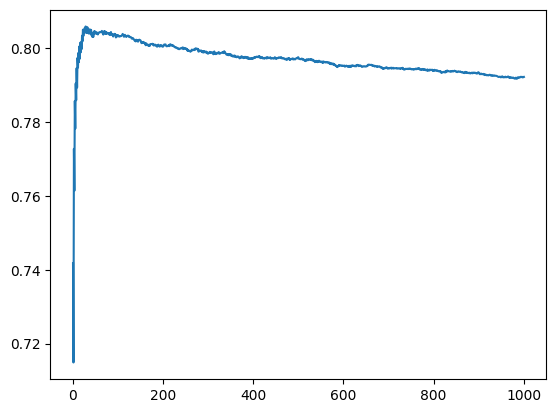

In [17]:
k = 1000
ks = np.arange(k) + 1
values = cross_validation(X, y, knn_all_k, k=k)
    
plt.plot(ks, values)
print(np.max(values), ks[np.argmax(values)])

k_opt = ks[np.argmax(values)]

In [18]:
X

array([[ 2.61960507e+00,  1.46145906e+00,  2.39604049e+00, ...,
        -2.52875949e+00,  1.15794991e+00,  1.00000000e+00],
       [ 3.04464058e+00,  1.94563192e+00,  2.52849663e+00, ...,
        -2.04344201e-03,  4.71619448e-01,  1.00000000e+00],
       [ 2.12652075e+00,  4.58828262e+00,  3.08492019e+00, ...,
        -2.04344201e-03,  4.51469567e-01,  1.00000000e+00],
       ...,
       [ 1.99505808e+00,  1.71244354e+00,  1.85749655e+00, ...,
        -2.04344201e-03,  4.28422184e-01,  1.00000000e+00],
       [ 1.79630332e+00,  5.47803123e-01,  1.68538684e+00, ...,
        -2.04344201e-03,  0.00000000e+00,  1.00000000e+00],
       [ 2.12652075e+00,  2.05846318e+00,  1.73483746e+00, ...,
        -2.04344201e-03,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
BATCH_SZ = 1024
predictions = []

for i in trange(0, len(X_test), BATCH_SZ):
    predictions.append(knn_all_k(X, y, X_test[i:i + BATCH_SZ], k=k_opt)[:, k_opt - 1])

predictions_knn_35 = np.concatenate(predictions)
predictions_knn_35[predictions_knn_35 == 0] = -1

result = data_test.Id.to_frame()
result['Prediction'] = predictions_knn_35
result.to_csv('knn_35_wo_nan', index=False)

  0%|          | 0/555 [00:00<?, ?it/s]